In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures

In [3]:
# Load the dataset
dataset = pd.read_csv('GPCACID_DATASET_toy.csv')

In [4]:
# Fill NaN values with 0
dataset = dataset.fillna(0)

# Check for NaN values in the dataset
print("NaN values in dataset after filling:", dataset.isna().sum().sum())

# Separate features and target variable
X = dataset.drop(columns=['Compressive Strength, Mpa'])
y = dataset['Compressive Strength, Mpa']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

NaN values in dataset after filling: 0


In [5]:
# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ensure no NaN, inf, or -inf values after scaling
X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0, posinf=0.0, neginf=0.0)

# Polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Ensure no NaN, inf, or -inf values after polynomial transformation
X_train_poly = np.nan_to_num(X_train_poly, nan=0.0, posinf=0.0, neginf=0.0)
X_test_poly = np.nan_to_num(X_test_poly, nan=0.0, posinf=0.0, neginf=0.0)

# Check for NaN values after polynomial transformation
print("NaN values in X_train_poly:", np.isnan(X_train_poly).sum())
print("NaN values in X_test_poly:", np.isnan(X_test_poly).sum())

NaN values in X_train_poly: 0
NaN values in X_test_poly: 0


In [6]:
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,), (100, 50, 50), (100, 100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [1000, 2000, 3000]
}

# Initialize the MLPRegressor
mlp = MLPRegressor(random_state=2, early_stopping=True, n_iter_no_change=10, validation_fraction=0.2)

# Initialize GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=5, scoring='r2', verbose=2)

# Fit the model
grid_search.fit(X_train_poly, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(cv=5,
             estimator=MLPRegressor(early_stopping=True, random_state=2,
                                    validation_fraction=0.2),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05, 0.01],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,), (100, 50, 50),
                                                (100, 100, 100)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [1000, 2000, 3000],
                         'solver': ['sgd', 'adam']},
             scoring='r2', verbose=2)

In [7]:
# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_model.predict(X_test_poly)
mse = mean_squared_error(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
mape = mean_absolute_percentage_error(y_test, y_pred_best)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_best)
evs = explained_variance_score(y_test, y_pred_best)

print("Mean Absolute Error (MAE): %.2f" % mae)
print("Mean Absolute Percentage Error (MAPE): %.2f" % mape)
print("Mean Squared Error (MSE): %.2f" % mse)
print("Root Mean Squared Error (RMSE): %.2f" % rmse)
print("R^2 Score: %.2f" % r2)
print("Explained Variance Score (EVS): %.2f" % evs)

Mean Absolute Error (MAE): 3.77
Mean Absolute Percentage Error (MAPE): 125036959081923.05
Mean Squared Error (MSE): 27.63
Root Mean Squared Error (RMSE): 5.26
R^2 Score: 0.90
Explained Variance Score (EVS): 0.90


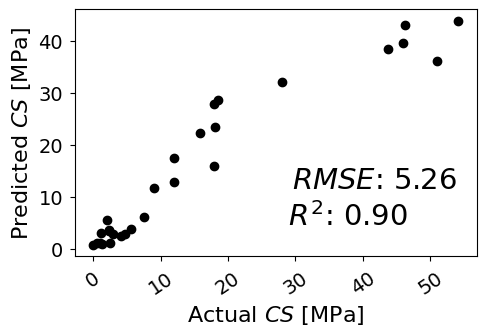

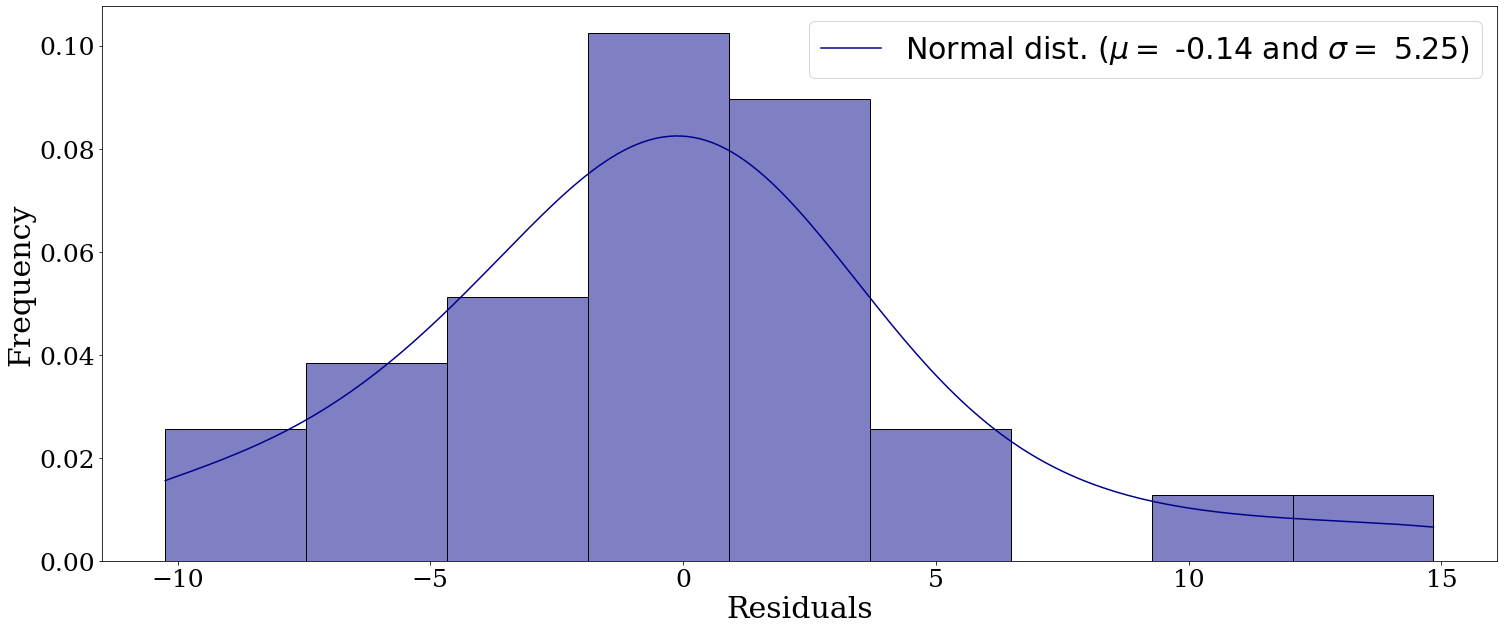

In [8]:
# Plotting
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
RSQ = r2_score(y_test, y_pred_best)

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.5))

ax1.scatter(y_test, y_pred_best, marker='o', color='black')

ax1.text(0.95, 0.25, ("$RMSE$: %0.02f" % rmse),
         verticalalignment='bottom', horizontalalignment='right',
         transform=ax1.transAxes,
         color='black', fontsize=21)

ax1.text(0.83, 0.1, ("$R^2$: %0.02f" % RSQ),
         verticalalignment='bottom', horizontalalignment='right',
         transform=ax1.transAxes,
         color='black', fontsize=21)

ax1.set_xlabel('Actual $CS$ [MPa]', fontsize=16)
ax1.tick_params(axis="x", labelsize=14, rotation=34)
ax1.xaxis.set_tick_params(pad=5)
ax1.set_ylabel('Predicted $CS$ [MPa]', fontsize=16)
ax1.tick_params(axis="y", labelsize=14)
ax1.yaxis.set_tick_params(pad=5)

plt.tight_layout(pad=1.2)
fig.savefig('Scatter_Plot_With_Tuning.jpg', format='jpeg', dpi=300, bbox_inches='tight')

residuals = (y_test - y_pred_best)
fig = plt.figure(figsize=(25, 10), dpi=72)
sns.histplot(residuals, kde=True, stat="density", color='darkblue')

(mu, sigma) = norm.fit(residuals)
plt.legend([r'Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best', fontsize=30)
plt.xlabel('Residuals', fontsize=30, fontname='Serif')
plt.ylabel('Frequency', fontsize=30, fontname='Serif')
plt.xticks(fontsize=25, fontname='Serif')
plt.yticks(fontsize=25, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.show()


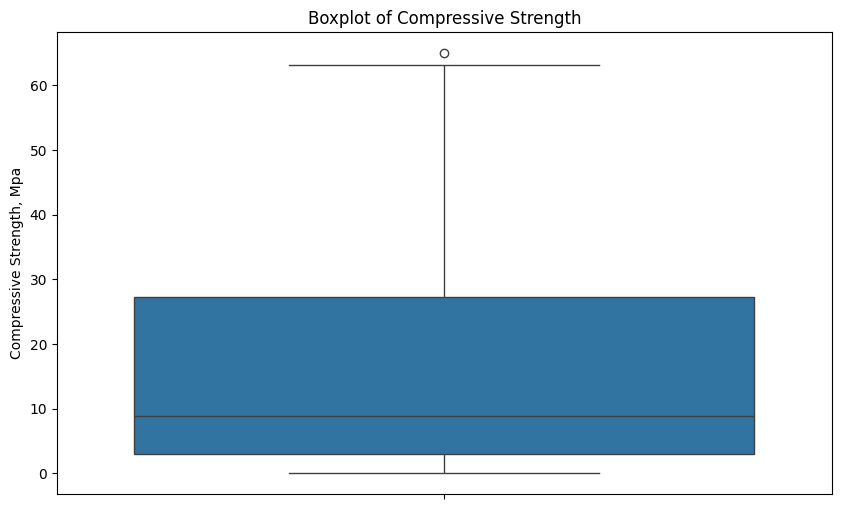

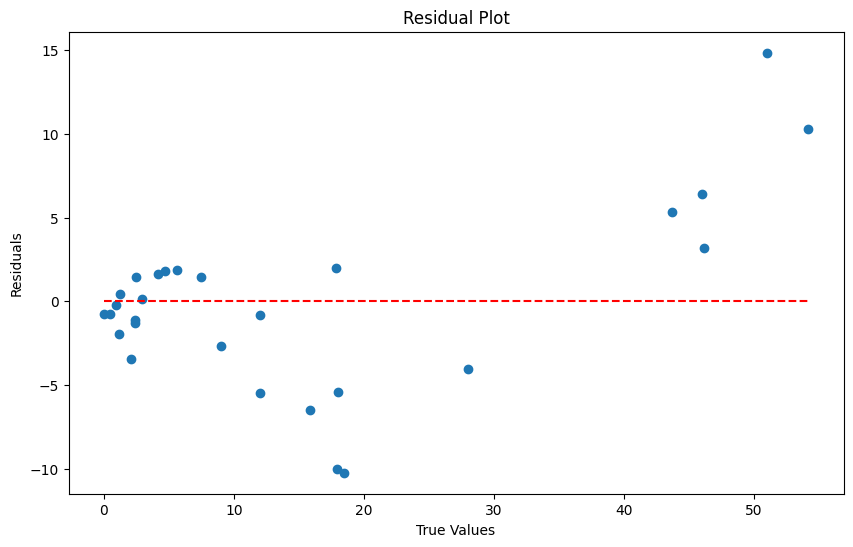

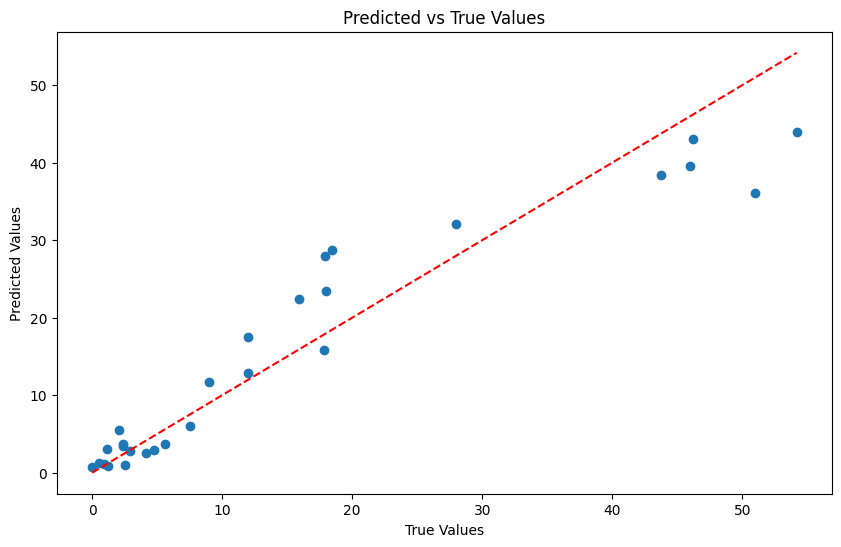

In [9]:
# Visualize the distribution of target variable
plt.figure(figsize=(10, 6))
sns.boxplot(y)
plt.title('Boxplot of Compressive Strength')
plt.show()

# Plot residuals
residuals = y_test - y_pred_best
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test), colors='red', linestyles='dashed')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Plot predictions vs true values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values')
plt.show()

In [10]:
# SHAP analysis
import shap
shap.initjs()

c:\Users\buce_\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Using 138 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/138 [00:00<?, ?it/s]

IndexError: index 149 is out of bounds for axis 0 with size 16

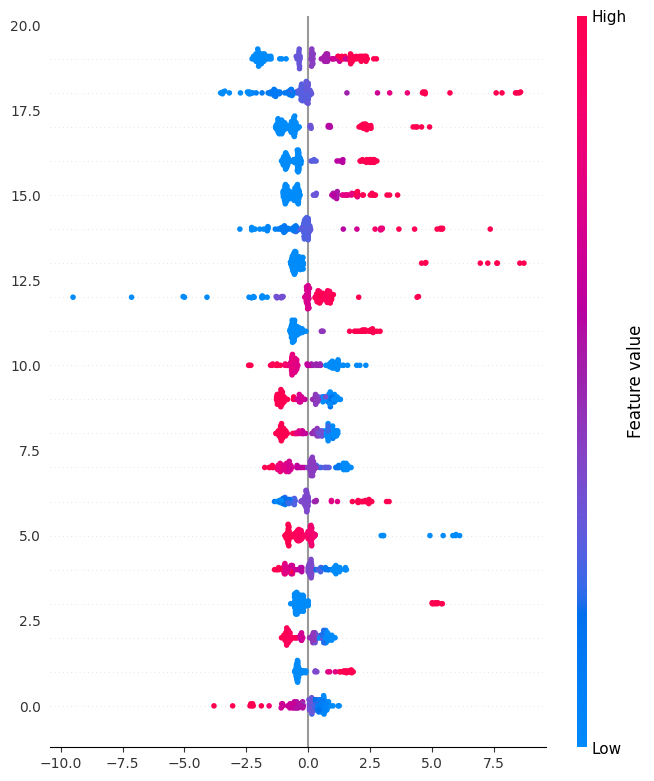

In [11]:
# Prepare the entire dataset
X_full = dataset.drop(columns=['Compressive Strength, Mpa']).to_numpy()

# Scale the entire dataset using the previously fitted scaler
X_full_scaled = scaler.transform(X_full)

# Apply the same polynomial transformation
X_full_poly = poly.transform(X_full_scaled)

# Ensure no NaN, inf, or -inf values after transformations
X_full_poly = np.nan_to_num(X_full_poly, nan=0.0, posinf=0.0, neginf=0.0)

# Create a SHAP explainer object for the best model
explainer = shap.KernelExplainer(best_model.predict, X_full_poly)
shap_values = explainer.shap_values(X_full_poly)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_full_poly, feature_names=dataset.columns.drop('Compressive Strength, Mpa'))